In [1]:
# Импорт необходимых библиотек
import copy
import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from tqdm import tqdm
from dateutil.relativedelta import relativedelta

import statsmodels
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import acf, adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

%matplotlib inline

Будем обрабатывать Amazon Historical Stock Price из пакета FAANG.

In [2]:
df = pd.read_csv('Amazon_Historical_StockPrice2.csv')
df.head(13)

,Date,Open,High,Low,Close,Adj Close,Volume
0,2016-03-28,584.400024,584.750000,575.559998,579.869995,579.869995,3121500
1,2016-03-29,580.150024,595.849976,576.500000,593.859985,593.859985,4392600
2,2016-03-30,596.710022,603.239990,595.000000,598.690002,598.690002,3890500
3,2016-03-31,599.280029,600.750000,592.210022,593.640015,593.640015,2681800
4,2016-04-01,590.489990,599.030029,588.299988,598.500000,598.500000,2917400
5,2016-04-04,599.000000,599.500000,590.549988,593.190002,593.190002,2470800
6,2016-04-05,590.770020,593.469971,585.250000,586.140015,586.140015,2308900
7,2016-04-06,587.520020,602.390015,587.500000,602.080017,602.080017,2849900
8,2016-04-07,598.760010,599.599976,589.080017,591.429993,591.429993,3189000
9,2016-04-08,594.320007,597.859985,589.000000,594.599976,594.599976,2591900


In [3]:
df.shape

(1260, 7)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1260 entries, 0 to 1259
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       1260 non-null   object 
 1   Open       1260 non-null   float64
 2   High       1260 non-null   float64
 3   Low        1260 non-null   float64
 4   Close      1260 non-null   float64
 5   Adj Close  1260 non-null   float64
 6   Volume     1260 non-null   int64  
dtypes: float64(5), int64(1), object(1)
memory usage: 69.0+ KB


# Предобработка

Проанализируем базовые статистики имеющихся признаков

In [5]:
df.describe()

,Open,High,Low,Close,Adj Close,Volume
count,1260.000000,1260.000000,1260.000000,1260.000000,1260.000000,1.260000e+03
mean,1677.254199,1694.635633,1657.249580,1676.504673,1676.504673,4.318210e+06
std,787.593224,798.250932,774.769809,786.149289,786.149289,2.089566e+06
min,580.150024,584.750000,575.559998,579.869995,579.869995,8.813000e+05
25%,967.990005,974.467499,959.544983,966.027512,966.027512,2.908675e+06
50%,1676.494995,1698.104980,1654.445007,1671.174988,1671.174988,3.716250e+06
75%,1932.977478,1951.877502,1908.004974,1928.965027,1928.965027,5.122475e+06
max,3547.000000,3552.250000,3486.689941,3531.449951,3531.449951,1.656500e+07


Привидём время к типу 'datetime' и сделаем его индексом для датасета. Изменим временной ряд - сделаем его по неделям, за семь дней возьмем среднее значение.

In [6]:
df['Date'] = pd.to_datetime(df['Date'], format='%Y/%m/%d')
df = df.resample('W', on='Date').mean()
df.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2016-04-03,590.206018,596.723999,585.514001,592.912000,592.912000,3400760.0
2016-04-10,594.074011,598.563989,588.276001,593.488000,593.488000,2682100.0
2016-04-17,607.842004,615.204004,605.137988,612.112000,612.112000,3194700.0
2016-04-24,629.591992,635.654004,621.764001,629.547998,629.547998,3741280.0
2016-05-01,627.223987,633.291992,617.122009,622.248010,622.248010,5491280.0


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 261 entries, 2016-04-03 to 2021-03-28
Freq: W-SUN
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       261 non-null    float64
 1   High       261 non-null    float64
 2   Low        261 non-null    float64
 3   Close      261 non-null    float64
 4   Adj Close  261 non-null    float64
 5   Volume     261 non-null    float64
dtypes: float64(6)
memory usage: 14.3 KB


Рассмотрим изменение цены

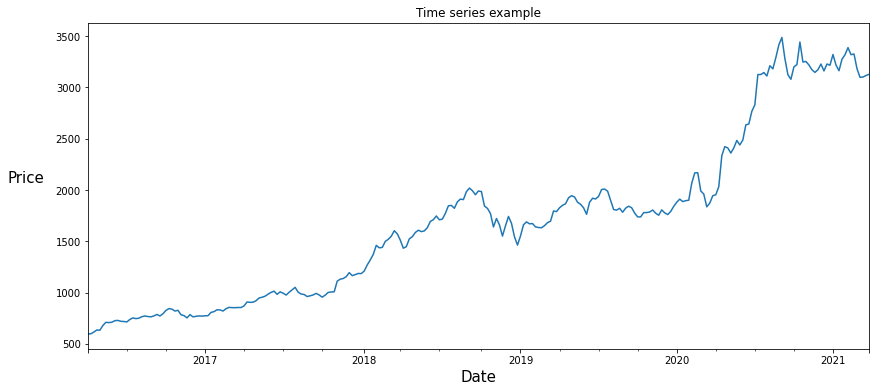

In [8]:
plt.figure(figsize=(14, 6))
plt.title('Time series example')
plt.xlabel('Date', fontsize=15)
plt.ylabel('Price', rotation=0, labelpad=30, fontsize=15)
df['High'].plot();

- Есть ли у данного ряда тренд? 
- Есть ли у данного ряда сезонность? 

Разложим ряд на компоненты и проверим ответы на вопросы

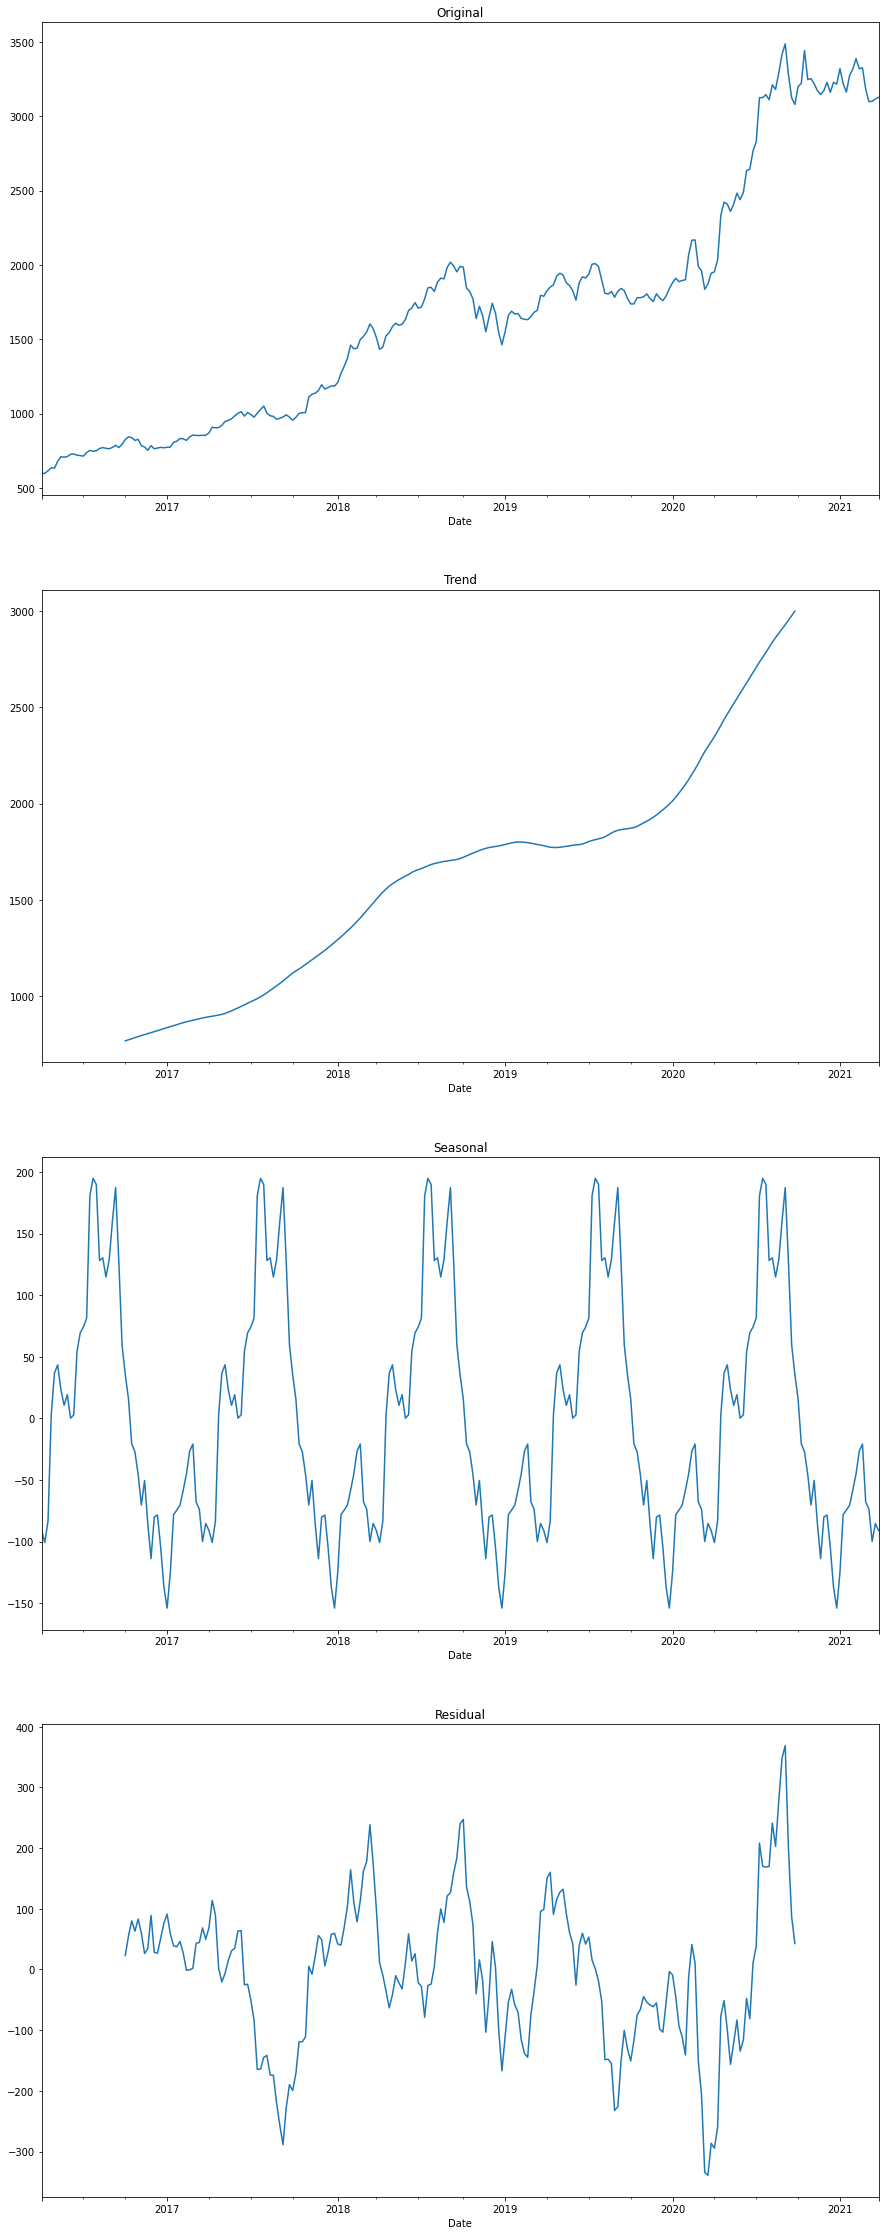

In [9]:
plt.figure(figsize=(15, 40))
decomposition = seasonal_decompose(df['High'])

ax = plt.subplot(411)
ax.set_title('Original')
decomposition.observed.plot(ax=ax)

ax = plt.subplot(412)
ax.set_title('Trend')
decomposition.trend.plot(ax=ax)

ax = plt.subplot(413)
ax.set_title('Seasonal')
decomposition.seasonal.plot(ax=ax)

ax = plt.subplot(414)
ax.set_title('Residual')
decomposition.resid.plot(ax=ax);

- Восходящий тренд
- Есть сезонность
- На последнем графике можем наблюдать шумы

## Проверим ряд на стационарность с помощью теста Дики-Фуллера

In [10]:
p_value = adfuller(df['High'])[1]
print({round(p_value, 4)})

{0.9558}


Полученный уровень значимости (p-value): 0.9558. 0.9558 > 0.05. Нулевая гипотеза не отвергнута в пользу альтернативной! Ряд нестационарен.

## Попробуем привести ряд к стационарному

In [11]:
df = df.drop(['Open', 'Low', 'Close', 'Adj Close', 'Volume'], axis=1)
df.head()

,High
Date,
2016-04-03,596.723999
2016-04-10,598.563989
2016-04-17,615.204004
2016-04-24,635.654004
2016-05-01,633.291992


Составим дифференцированный ряд

In [12]:
df['HighDiff_1'] = df['High'] - df['High'].shift(1) 
df.head()

,High,HighDiff_1
Date,,
2016-04-03,596.723999,NaN
2016-04-10,598.563989,1.839990
2016-04-17,615.204004,16.640015
2016-04-24,635.654004,20.450000
2016-05-01,633.291992,-2.362012


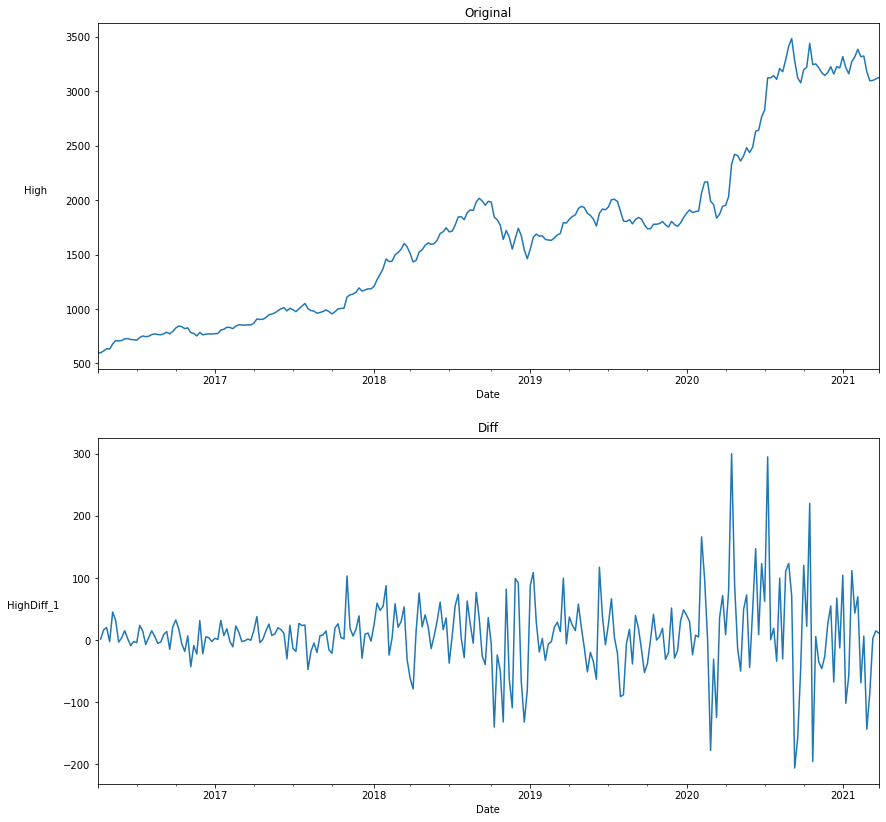

In [13]:
plt.subplots(nrows=2, ncols=1, figsize=(14, 14))

ax = plt.subplot(211)
ax.set_title('Original')
ax.set_ylabel('High', rotation=0, labelpad=30)
df['High'].plot(ax=ax);

ax = plt.subplot(212)
ax.set_title('Diff')
ax.set_ylabel('HighDiff_1', rotation=0, labelpad=30)
df['HighDiff_1'].plot(ax=ax);

Проверим гипотезу для нового ряда

In [14]:
p_value = adfuller(df['HighDiff_1'][1:])[1]
print({round(p_value, 4)})

{0.0}


Полученный уровень значимости (p-value): 0.0. 0.0 < 0.05. Нулевая гипотеза отвергнута в пользу альтернативной! Ряд стационарен.
Хотя, если посмотрим на график, то увидим, что начиная с 2020 года дисперсия значительно увеличилась, что говорит о нестационарности ряда.
Прологорифмируем ряд и снова составим дифференцированный ряд для него.

In [15]:
df['HighLog'] = np.log(df['High'])
df['HighLogDiff_1'] = df['HighLog'] - df['HighLog'].shift(1)
df.head()

,High,HighDiff_1,HighLog,HighLogDiff_1
Date,,,,
2016-04-03,596.723999,NaN,6.391455,NaN
2016-04-10,598.563989,1.839990,6.394533,0.003079
2016-04-17,615.204004,16.640015,6.421954,0.027420
2016-04-24,635.654004,20.450000,6.454654,0.032700
2016-05-01,633.291992,-2.362012,6.450932,-0.003723


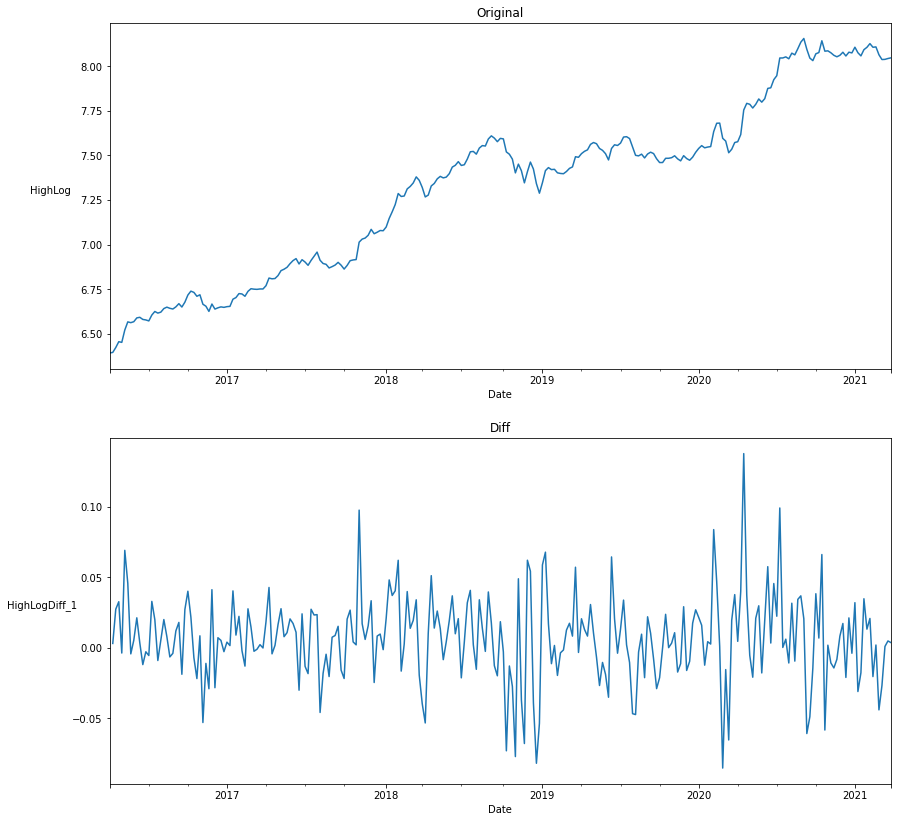

In [16]:
plt.subplots(nrows=2, ncols=1, figsize=(14, 14))

ax = plt.subplot(211)
ax.set_title('Original')
ax.set_ylabel('HighLog', rotation=0, labelpad=30)
df['HighLog'].plot(ax=ax);

ax = plt.subplot(212)
ax.set_title('Diff')
ax.set_ylabel('HighLogDiff_1', rotation=0, labelpad=30)
df['HighLogDiff_1'].plot(ax=ax);

Дисперсия стабилизировалась

In [17]:
p_value = adfuller(df['HighLogDiff_1'][1:])[1]
print({round(p_value, 4)})

{0.0}


Распредение признака 'HighLogDiff_1' похоже на нормальное

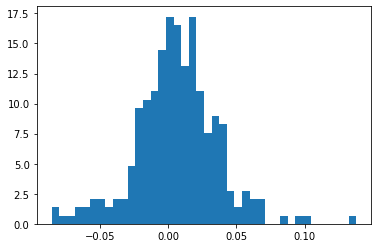

In [18]:
plt.hist(df['HighLogDiff_1'], density=True, bins=40);

Построим корелограмму и проверим наличие значимых коррелаций

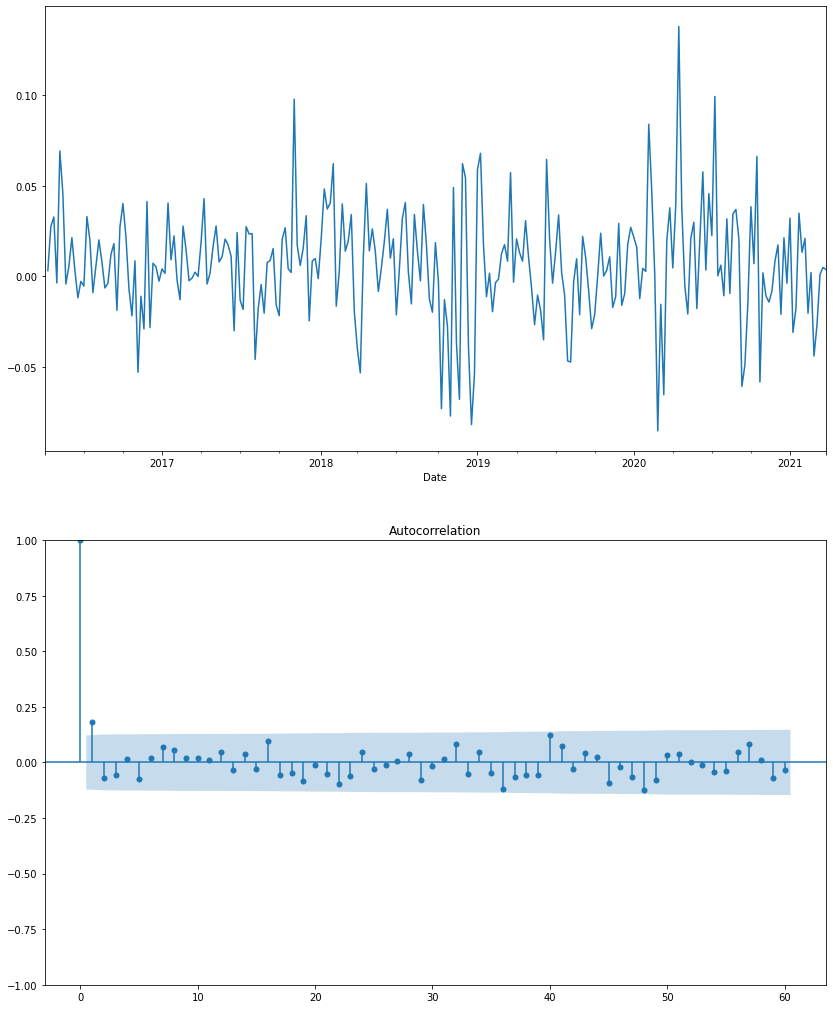

In [19]:
plt.figure(figsize=(14, 18))

ax = plt.subplot(211)
df['HighLogDiff_1'].plot(ax=ax)

ax = plt.subplot(212)
plot_acf(df['HighLogDiff_1'][1:], lags=60, ax=ax);

Среди 60 корреляций можно выделить только 1-2 значимыx, при этом их значимость довольна мала

# Перейдем к предсказанию значений временного ряда

Сгенерируем p, d, q,P, D, Q

In [20]:
d=1
D=1

q = range(1, 5)
Q = range(1, 3)

p = range(1, 5)
P = range(3, 5)

Сгенерируем различные комбинации (p, q, P, Q). 

d, D не включаем, так как всегда берем одни и те же значения.

In [21]:
from itertools import product
parameters = product(p, q, P, Q)
parameters_list = list(parameters)
len(parameters_list)

64

Проверим все модели SARIMAX с данными параметрами и выберем лучшую.

In [22]:
%%time
#warnings.filterwarnings('ignore')
import statsmodels.api as sm


results = []
best_aic = float("inf")

for param in tqdm(parameters_list):
    try:
        model = sm.tsa.statespace.SARIMAX(
            df['HighLog'], 
            order=(param[0], d, param[1]), 
            seasonal_order=(param[2], D, param[3], 12)
        ).fit(disp=-1)
    except ValueError:
        print('wrong parameters:', param)
        continue
    aic = model.aic
    if aic < best_aic:
        best_model = model
        best_aic = aic
        best_param = param
    results.append([param, model.aic])

#warnings.filterwarnings('default')

  0%|                                                                                                                                                              | 0/64 [00:00<?, ?it/s]d:\study\dataanalysis\lab3\venv\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
  2%|██▎                                                                                                                                                   | 1/64 [00:04<05:07,  4.87s/it]d:\study\dataanalysis\lab3\venv\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
  3%|████▋                                                                                                                                                 | 2/64 [0

Wall time: 15min 9s


Рейтинг значений AIC:

In [23]:
result_table = pd.DataFrame(results)
result_table.columns = ['parameters', 'aic']
print(result_table.sort_values(by = 'aic', ascending=True).head())

      parameters          aic
2   (1, 1, 4, 1) -1001.655992
6   (1, 2, 4, 1) -1000.012374
18  (2, 1, 4, 1)  -999.131356
14  (1, 4, 4, 1)  -998.565808
34  (3, 1, 4, 1)  -998.390284


Модель со вторым набором параметров (1, 1, 4, 1) имеет наименьший показатель AIC(-1001.655992). Считаем эти параметры оптимальными.

Проанализируем нашу модель более подробно.

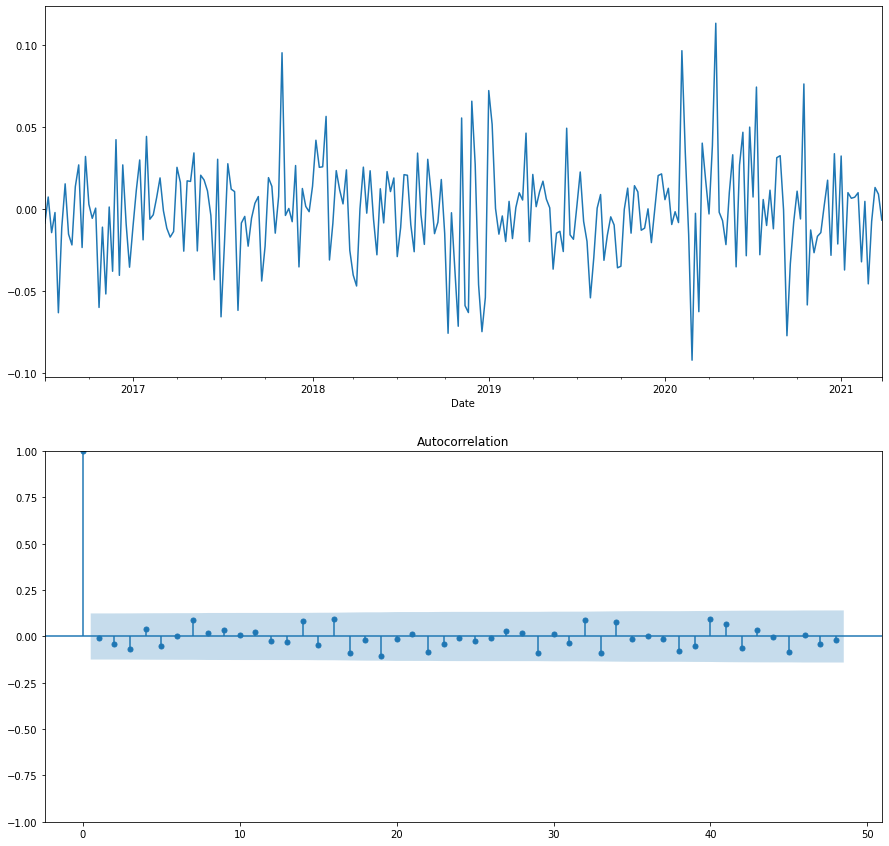

In [24]:
plt.figure(figsize=(15,15))

plt.subplot(211)
best_model.resid[13:].plot()

ax = plt.subplot(212)
sm.graphics.tsa.plot_acf(best_model.resid[13:].values.squeeze(), lags=48, ax=ax);

In [25]:
print(best_model.summary())

                                     SARIMAX Results                                      
Dep. Variable:                            HighLog   No. Observations:                  261
Model:             SARIMAX(1, 1, 1)x(4, 1, 1, 12)   Log Likelihood                 508.828
Date:                            Wed, 24 Nov 2021   AIC                          -1001.656
Time:                                    17:36:52   BIC                           -973.549
Sample:                                04-03-2016   HQIC                          -990.341
                                     - 03-28-2021                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0345      0.264      0.131      0.896      -0.484       0.553
ma.L1          0.1942      0.261   

Обучим модель на 80% временного ряда Предскажем оставшиеся 20% ряда с помощью модели

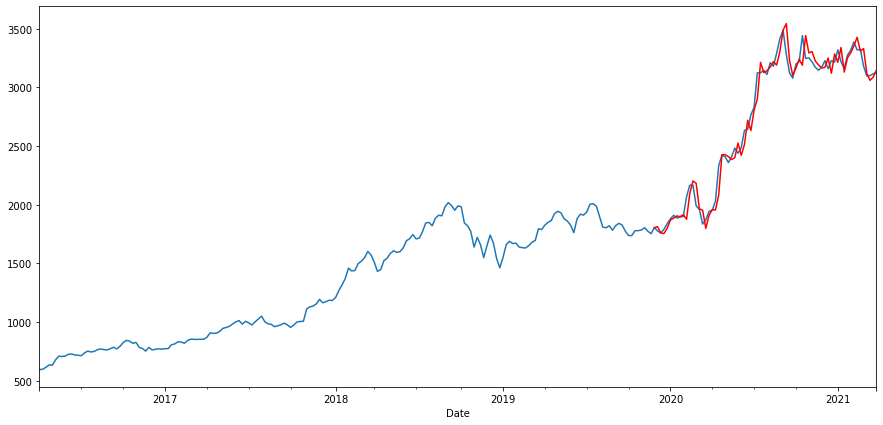

In [26]:
df['Model'] = np.exp(best_model.fittedvalues)

plt.figure(figsize=(15,7))
df['High'][-261:].plot()
df['Model'][-70:].plot(c='r');

In [27]:
print(df.shape)
df.tail()

(261, 5)


,High,HighDiff_1,HighLog,HighLogDiff_1,Model
Date,,,,,
2021-02-28,3181.795996,-143.381494,8.065201,-0.044077,3330.254978
2021-03-07,3097.597998,-84.197998,8.038382,-0.026819,3120.851550
2021-03-14,3100.554004,2.956006,8.039336,0.000954,3059.981690
2021-03-21,3115.623975,15.069971,8.044185,0.004849,3087.407641
2021-03-28,3127.066016,11.442041,8.047850,0.003666,3148.101995


Проверим точность модели с помощью метрики MAPE:

In [28]:
mape = np.mean(np.abs(df['Model'] - df['High'])/np.abs(df['High']))  # MAPE
print(mape)

0.11648243400842023


Предскажем данные, выходящие за рамки нашего временного ряда (последующие 70 недель)

In [29]:
predict_len = 70

new_close_value = df[['High', 'Model']]
future_date = [
    datetime.datetime.strptime("2021-03-28", "%Y-%m-%d") + relativedelta(weeks=x)
    for x in range(0, predict_len)
]

future_df = pd.DataFrame(index=future_date, columns=['High', 'Model'])
new_close_value = pd.concat([new_close_value, future_df])

print(new_close_value.shape)
new_close_value.tail()

(331, 2)


,High,Model
2022-06-26,NaN,NaN
2022-07-03,NaN,NaN
2022-07-10,NaN,NaN
2022-07-17,NaN,NaN
2022-07-24,NaN,NaN


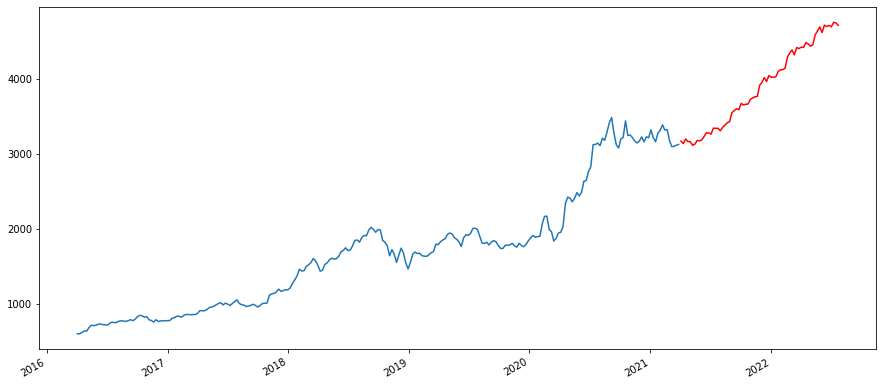

In [30]:
new_close_value['Model'] = np.exp(best_model.predict(start=261, end=330))

plt.figure(figsize=(15,7))
new_close_value['High'].plot()
new_close_value['Model'].plot(c='r');

In [31]:
new_close_value.tail()

,High,Model
2022-06-26,NaN,4715.784544
2022-07-03,NaN,4697.355088
2022-07-10,NaN,4757.170314
2022-07-17,NaN,4749.372524
2022-07-24,NaN,4716.992536
